# Titanic: Machine Learning from Disaster

[*Clique aqui*](https://www.kaggle.com/c/titanic/) *para o link do problema no [Kaggle](kaggle.com)*

---

Este é um dos desafios de *Machine Learning* mais famosos, promovida pelo site (kaggle.com)[kaggle.com], uma plataforma de competições de análise preditiva. Sua popularidade fez com que virasse um **Hello, World!** de Ciência de Dados.


## 1. Definição do problema 

Apesar dos sobreviventes contarem com a sorte, alguns fatores influenciaram algumas pessoas a terem mais ou menos chances de sobreviverem, como sexo e idade ("Mulheres e crianças primeiro!").


### Objetivo

O objetivo é prever, com base nos regressores, construir um modelo para prever se a pessoa sobreviveria ou não ao acidente trágico. A pontuação será feita exclusivamente pela acurácia, isto é, pelo percentual de acertos em relação ao total.

## 2. Obtenção dos dados

Os dados estão disponíveis no Kaggle, e estão divididos em dois grupos:
* Dataset de treino (`train.csv`)
    * Deve ser usado para criar e treinar o modelo de *Machine Learning*
    * Possui como linhas os passageiros do Titanic, e como colunas várias informações sobre cada passageiro
    * Diz se a pessoa sobreviveu ou não
* Dataset de teste (`test.csv`)
    * Deve ser usado como dados nunca vistos pelo modelo
    
Está disponível também um gabarito de como devem ser feitas as submissões (`gender_submission.csv`). 

Para baixar os dados, é necessário ter uma conta no Kaggle. Após isso, é só extrair os arquivos na pasta desejada, de preferência uma de fácil acesso.

In [10]:
# importing libraries
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedKFold

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# allow showing all columns
pd.options.display.max_columns = None

# seed for random states
SEED = 357 # inside joke

# magical commands for plotting
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [12]:
print(f"Number of values for training: {train.shape[0]}")

Number of values for training: 891


## 3. Explorando os Dados

Serão estuda

### Dicionário de Dados

* PassengerId: Número de identificação do passageiro
* Survived: Informa se o passageiro sobreviveu ao desastre
    * 0 = Não
    * 1 = Sim
* Pclass: Classe do bilhete
    * 1 = 1ª Classe
    * 2 = 2ª Classe
    * 3 = 3ª Classe
* Name: Nome do passageiro
* Sex: Sexo do passageiro
* Age: Idade do passageiro
* SibSp: Quantidade de cônjuges e irmãos a bordo
* Parch: Quantidade de pais e filhos a bordo
* Ticket: Número da passagem
* Fare: Preço da Passagem
* Cabin: Número da cabine do passageiro
* Embarked: Porto no qual o passageiro embarcou
    * C = Cherbourg
    * Q = Queenstown
    * S = Southampton

In [15]:
def concat_df(train_data, test_data):
    """Returns a concatenated DataFrame of training and test set"""
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    """Returns divided DataFrames of training and test set"""
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

In [16]:
df_all = concat_df(train, test)
df_all.sample(5)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
248,37.0,D35,S,52.5542,"Beckwith, Mr. Richard Leonard",1,249,1,male,1,1.0,11751
39,14.0,NaN,C,11.2417,"Nicola-Yarred, Miss. Jamila",0,40,3,female,1,1.0,2651
934,30.0,NaN,S,13.0000,"Corbett, Mrs. Walter H (Irene Colvin)",0,935,2,female,0,NaN,237249
568,NaN,NaN,C,7.2292,"Doharr, Mr. Tannous",0,569,3,male,0,0.0,2686
193,3.0,F2,S,26.0000,"Navratil, Master. Michel M",1,194,2,male,1,1.0,230080


In [7]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1046 non-null   float64
 1   Cabin        295 non-null    object 
 2   Embarked     1307 non-null   object 
 3   Fare         1308 non-null   float64
 4   Name         1309 non-null   object 
 5   Parch        1309 non-null   int64  
 6   PassengerId  1309 non-null   int64  
 7   Pclass       1309 non-null   int64  
 8   Sex          1309 non-null   object 
 9   SibSp        1309 non-null   int64  
 10  Survived     891 non-null    float64
 11  Ticket       1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [8]:
def display_missing(df):
    """Displays missing value for each column of the DataFrame"""
    for col in df.columns.tolist():          
        print(f'\t{col} column missing values: {df[col].isnull().sum()}')
        
        
print('Missing values in set:')
display_missing(df_all)

Missing values in set:
	Age column missing values: 263
	Cabin column missing values: 1014
	Embarked column missing values: 2
	Fare column missing values: 1
	Name column missing values: 0
	Parch column missing values: 0
	PassengerId column missing values: 0
	Pclass column missing values: 0
	Sex column missing values: 0
	SibSp column missing values: 0
	Survived column missing values: 418
	Ticket column missing values: 0


In [18]:
(df_all.isnull().sum() / df_all.shape[0]).sort_values(ascending=False)

Cabin          0.774637
Survived       0.319328
Age            0.200917
Embarked       0.001528
Fare           0.000764
Ticket         0.000000
SibSp          0.000000
Sex            0.000000
Pclass         0.000000
PassengerId    0.000000
Parch          0.000000
Name           0.000000
dtype: float64

In [19]:
df_all.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


## 4. Preparação dos dados

In [5]:
def transform_sex(valor):
    """changes categorical value of sex to a binary numerical value of sex"""
    return 1 if valor == 'female' else 0

In [9]:
df_all['Sex_binary'] = df_all['Sex'].map(transform_sex)

In [10]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print(f'Median age of Pclass {pclass} {sex}s: {age_by_pclass_sex[sex][pclass]}')
print(f'Median age of all passengers: {df_all["Age"].median()}')

# Filling the missing values in Age with the medians of Sex and Pclass groups
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


In [11]:
df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Sex_binary
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,1
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,1


In [12]:
# Filling the missing values in Embarked with the mode
mode_embarked = df_all['Embarked'].mode().values[0]
print(f'The mode, i.e. the most common value, in "Embaked", is {mode_embarked}')
df_all['Embarked'].fillna(mode_embarked, inplace=True)

The mode, i.e. the most common value, in "Embaked", is S


In [13]:
df_all[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Sex_binary
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,0


In [14]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df_all['Fare'].fillna(med_fare, inplace=True)

In [15]:
df_all.isnull().any()

Age            False
Cabin           True
Embarked       False
Fare           False
Name           False
Parch          False
PassengerId    False
Pclass         False
Sex            False
SibSp          False
Survived        True
Ticket         False
Sex_binary     False
dtype: bool

In [16]:
train, test = divide_df(df_all)

In [17]:
variables = ['Sex_binary', 'Age']

X = train[variables]
y = train['Survived']

In [18]:
test.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Ticket,Sex_binary
891,34.5,NaN,Q,7.8292,"Kelly, Mr. James",0,892,3,male,0,330911,0
892,47.0,NaN,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,female,1,363272,1
893,62.0,NaN,Q,9.6875,"Myles, Mr. Thomas Francis",0,894,2,male,0,240276,0
894,27.0,NaN,S,8.6625,"Wirz, Mr. Albert",0,895,3,male,0,315154,0
895,22.0,NaN,S,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,female,1,3101298,1


## Novas variáveis para o modelo

In [19]:
train['Embarked_S'] = (train['Embarked'] == 'S').astype(int)
train['Embarked_C'] = (train['Embarked'] == 'C').astype(int)

train['Cabine_nula'] = train['Cabin'].isnull().astype(int)

train['Name_contains_Miss'] = train['Name'].str.contains('Miss').astype(int)
train['Name_contains_Mrs'] = train['Name'].str.contains('Mrs').astype(int)

train['Name_contains_Master'] = train['Name'].str.contains('Master').astype(int)
train['Name_contains_Col'] = train['Name'].str.contains('Col').astype(int)
train['Name_contains_Major'] = train['Name'].str.contains('Major').astype(int)
train['Name_contains_Mr'] = train['Name'].str.contains('Mr').astype(int)

In [20]:
variables = [
    'Sex_binary', 'Age', 'Pclass',
    'SibSp', 'Parch', 'Fare',
    'Embarked_S', 'Embarked_C', 'Cabine_nula', 
    'Name_contains_Miss', 'Name_contains_Mrs', 'Name_contains_Master',
    'Name_contains_Col', 'Name_contains_Major', 'Name_contains_Mr'
]

X = train[variables]
y = train['Survived']

# Construção do Modelo

## Modelo com RandomForest

In [54]:
results_rf = []
kf = RepeatedKFold(n_splits=2, n_repeats=10, random_state=SEED)

for lines_train, lines_valid in kf.split(X):
    X_train, X_valid = X.iloc[lines_train], X.iloc[lines_valid]
    y_train, y_valid = y.iloc[lines_train], y.iloc[lines_valid]

    model = RandomForestClassifier(criterion='gini',
                                   n_estimators=2000,
                                   max_depth=7,
                                   min_samples_split=6,
                                   min_samples_leaf=6,
                                   max_features='auto',
                                   oob_score=True,
                                   n_jobs=-1,
                                   random_state=SEED)
    model.fit(X_train, y_train)

    p = model.predict(X_valid)

    acc = np.mean(y_valid == p)
    results_rf.append(acc)
    print(f"Acc: {acc}")
    print()

Acc: 0.8295964125560538

Acc: 0.8044943820224719

Acc: 0.8475336322869955

Acc: 0.7910112359550562

Acc: 0.8340807174887892

Acc: 0.8112359550561797

Acc: 0.8318385650224215

Acc: 0.7842696629213484

Acc: 0.8026905829596412

Acc: 0.8269662921348314

Acc: 0.820627802690583

Acc: 0.8247191011235955

Acc: 0.8026905829596412

Acc: 0.8112359550561797

Acc: 0.8183856502242153

Acc: 0.8269662921348314

Acc: 0.8116591928251121

Acc: 0.8157303370786517

Acc: 0.8251121076233184

Acc: 0.8157303370786517



In [55]:
np.mean(results_rf)

0.8168287398599287

(array([1., 1., 2., 1., 5., 2., 4., 3., 0., 1.]),
 array([0.78426966, 0.79059606, 0.79692246, 0.80324885, 0.80957525,
        0.81590165, 0.82222804, 0.82855444, 0.83488084, 0.84120724,
        0.84753363]),
 <a list of 10 Patch objects>)

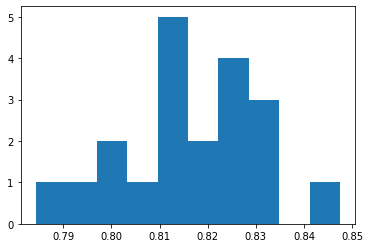

In [56]:
pylab.hist(results_rf)

## Modelo com LogisticRegression

In [57]:
results_lr = []
kf = RepeatedKFold(n_splits=2, n_repeats=20, random_state=SEED)

for linhas_treino, linhas_valid in kf.split(X):
    print(f'Treino: {linhas_treino.shape[0]}')
    print(f'Valid: {linhas_valid.shape[0]}')
    
    X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
    y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]
    
    model = LogisticRegression(random_state=SEED)
    model.fit(X_treino, y_treino)
    
    p = model.predict(X_valid)
    
    acc = np.mean(y_valid == p)
    results_lr.append(acc)
    print(f'Acc: {acc}')
    print()

Treino: 445
Valid: 446
Acc: 0.8408071748878924

Treino: 446
Valid: 445
Acc: 0.8

Treino: 445
Valid: 446
Acc: 0.8430493273542601

Treino: 446
Valid: 445
Acc: 0.8134831460674158

Treino: 445
Valid: 446
Acc: 0.8228699551569507

Treino: 446
Valid: 445
Acc: 0.8269662921348314

Treino: 445
Valid: 446
Acc: 0.8183856502242153

Treino: 446
Valid: 445
Acc: 0.8157303370786517

Treino: 445
Valid: 446
Acc: 0.8071748878923767

Treino: 446
Valid: 445
Acc: 0.8382022471910112

Treino: 445
Valid: 446
Acc: 0.827354260089686

Treino: 446
Valid: 445
Acc: 0.8359550561797753

Treino: 445
Valid: 446
Acc: 0.8228699551569507

Treino: 446
Valid: 445
Acc: 0.8067415730337079

Treino: 445
Valid: 446
Acc: 0.827354260089686

Treino: 446
Valid: 445
Acc: 0.8359550561797753

Treino: 445
Valid: 446
Acc: 0.8094170403587444

Treino: 446
Valid: 445
Acc: 0.8247191011235955

Treino: 445
Valid: 446
Acc: 0.8183856502242153

Treino: 446
Valid: 445
Acc: 0.8112359550561797

Treino: 445
Valid: 446
Acc: 0.827354260089686

Treino: 44

## Comparação dos dois modelos

((array([3., 4., 5., 5., 3., 8., 3., 5., 2., 2.]),
  array([0.8       , 0.8047191 , 0.8094382 , 0.8141573 , 0.8188764 ,
         0.82359551, 0.82831461, 0.83303371, 0.83775281, 0.84247191,
         0.84719101]),
  <a list of 10 Patch objects>),
 (array([1., 1., 2., 1., 5., 2., 4., 3., 0., 1.]),
  array([0.78426966, 0.79059606, 0.79692246, 0.80324885, 0.80957525,
         0.81590165, 0.82222804, 0.82855444, 0.83488084, 0.84120724,
         0.84753363]),
  <a list of 10 Patch objects>))

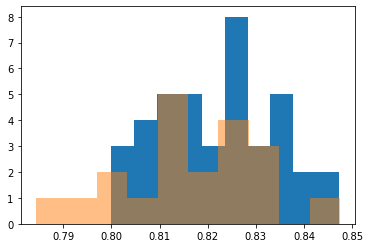

In [61]:
pylab.hist(results_lr), pylab.hist(results_rf, alpha=0.5)

In [62]:
means = [np.mean(results_rf), np.mean(results_lr)]

for i in range(2):
    print(f'Mean of model #{i+1}: {means[i]}')

Mean of model #1: 0.8168287398599287
Mean of model #2: 0.822840227742228


In [83]:
test['Embarked_S'] = (test['Embarked'] == 'S').astype(int)
test['Embarked_C'] = (test['Embarked'] == 'C').astype(int)

test['Cabine_nula'] = test['Cabin'].isnull().astype(int)

test['Name_contains_Miss'] = test['Name'].str.contains('Miss').astype(int)
test['Name_contains_Mrs'] = test['Name'].str.contains('Mrs').astype(int)

test['Name_contains_Master'] = test['Name'].str.contains('Master').astype(int)
test['Name_contains_Col'] = test['Name'].str.contains('Col').astype(int)
test['Name_contains_Major'] = test['Name'].str.contains('Major').astype(int)
test['Name_contains_Mr'] = test['Name'].str.contains('Mr').astype(int)

In [94]:
model_rf = RandomForestClassifier(criterion='gini',
                                  n_estimators=2250,
                                  max_depth=8,
                                  min_samples_split=6,
                                  min_samples_leaf=6,
                                  max_features='auto',
                                  oob_score=True,
                                  n_jobs=-1,
                                  random_state=SEED)
model_rf.fit(X, y)

p = model_rf.predict(test[variables])
p = p.astype(int)

# 6. Submissão ao Kaggle

In [95]:
sub = pd.Series(p, index=test['PassengerId'], name='Survived')
sub.shape

(418,)

In [96]:
sub.to_csv('model_with_random_forest.csv', header=True)

In [97]:
!head -n10 model_with_random_forest.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1
